# Sound Effects

Let's implement some simple sound effects in Numpy and then translate them to use the array API.

In [1]:
import scipy

from IPython.display import Audio

To get started we have a recording of someone playing a few notes on a guitar.

The effect we will apply is called Tremolo. You probably have heard it before in a song,
but like me might not know it by name.

What it does is modify the amplitude (loudness) of the recording with a low
frequency. Typically a few Hertz.

In [2]:
rate, guitar = scipy.io.wavfile.read("guitar.wav")

In [3]:
Audio(guitar, rate=rate)

In [4]:
import numpy as np


def simple_tremolo(audio, frequency, depth, sample_rate=44100):
    """
    Apply a simple tremolo effect to the input audio signal.

    Parameters:
    - audio (ndarray): Input audio signal
    - frequency (float): Frequency of the tremolo effect (Hz)
    - depth (float): Magnitude of the tremolo effect (0-1)

    Returns:
    - ndarray: Output audio signal with tremolo effect
    """
    t = np.arange(len(audio)) / float(sample_rate)
    modulator = np.sin(2 * np.pi * frequency * t) # / 2 + 0.5
    output = audio * (1 + depth * modulator)
    return output

In [5]:
Audio(simple_tremolo(guitar, 10, 0.65, sample_rate=rate), rate=rate)

## Exercise

A few minutes break for you to implement a version that uses the array API. Below some imports that will be useful.

The `guitar` numpy array has been converted to a PyTorch array, but you can also try using CuPy.

In [6]:
import torch
import array_api_compat


guitar_torch = torch.asarray(guitar)

In [7]:
#%load tremolo.py

In [8]:
Audio(simple_tremolo(guitar_torch, 10, 0.65, sample_rate=rate), rate=rate)

## Visualisation

This effect is nice because you can hear it and it is easy to visualise when looking at the waveform.

Let's do some plotting with the `librosa` library that has useful built in visualisation tools.

One thing to note is that `librosa` does not use the array API, like `matplotlib`, which means
we will need to convert our PyTorch array to a Numpy array. Currently this requires a small
library aware conversion function. Different array libraries have different methods for
allowing you to convert back to a Numpy array.

In [9]:
import librosa
import matplotlib.pyplot as plt

In [10]:
def convert_to_numpy(array, xp):
    """Convert X into a NumPy ndarray on the CPU."""
    xp_name = xp.__name__

    if xp_name in {"array_api_compat.torch", "torch"}:
        return array.cpu().numpy()
    elif xp_name == "cupy.array_api":
        return array._array.get()
    elif xp_name in {"array_api_compat.cupy", "cupy"}:
        return array.get()

    return np.asarray(array)


def waveshow(data, title="Amplitude"):
    xp = array_api_compat.get_namespace(data)
    data = xp.astype(data, xp.float32)
    data /= xp.max(xp.abs(data))

    data_np = convert_to_numpy(data, xp)
    librosa.display.waveshow(data_np, sr=44100)
    plt.title(title)

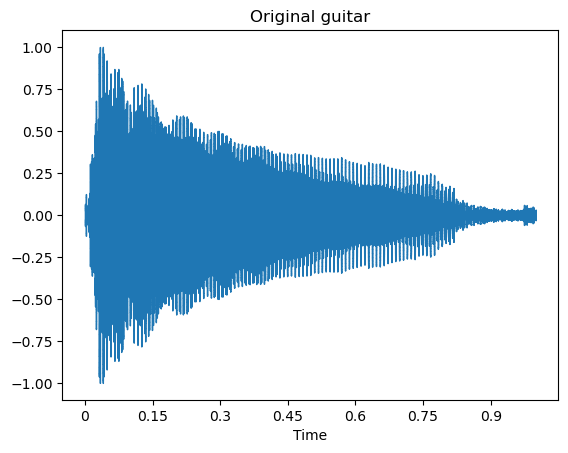

In [11]:
# Selecting one second from the sample where a note is being played
one_second = slice(int(1.5*rate), int(2.5*rate))

waveshow(guitar[one_second], title="Original guitar")

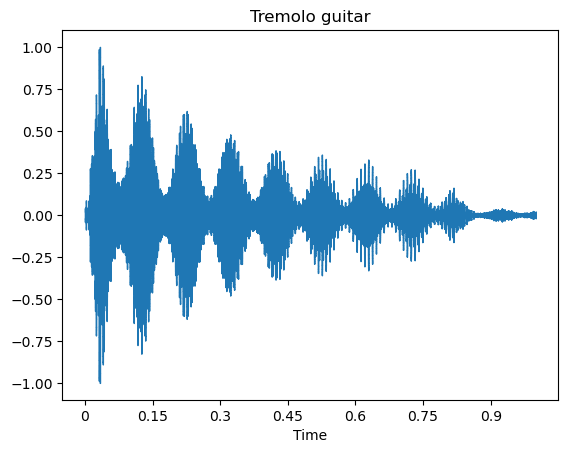

In [12]:
tremolo_guitar = simple_tremolo(guitar_torch, 10, 0.65, sample_rate=rate)
waveshow(tremolo_guitar[one_second], title="Tremolo guitar")

In [ ]:
from ipywebrtc import AudioRecorder, CameraStream

#from google.colab import output
#output.enable_custom_widget_manager()

## Recording some audio

We need some sound to work on. Luckily we can just record something with the microphone in our computers.

In [ ]:
def record_audio():
    camera = CameraStream(constraints={'audio': True, 'video': False})
    recorder = AudioRecorder(stream=camera)
    return recorder

def convert_audio(recorder):
    recorder.save("recording.webm")
    !ffmpeg -i recording.webm -ac 1 -ar 44100 -f wav my_recording.wav -y -hide_banner -loglevel panic

    rate, rec = scipy.io.wavfile.read("my_recording.wav")

    return rate, rec

In [ ]:
recorder = record_audio()
recorder

In [ ]:
sample_rate, audio = convert_audio(recorder)

## Speeding up a recording

You all know the "playback speed" button on YouTube. Let's implement a simple version of this.

When we record sound we create a set of samples. Typically something like 20000 samples per second. This means a one second
recording contains about 20000 samples. To play back a recording at the right speed we need to know the sample rate,
how many samples were recorded per second.

To speed up a recording by ten percent we can take an existing 5second recording made of `100_000` samples and reduce the total number
of samples to `100_000 / 1.1 = 90910` samples. When we then play back this smaller number of samples at the same rate, we will get
a shorter recording.

XXX insert diagram

In [ ]:
import numpy as np


def speed_up_audio(audio_data, factor=1.1):
    """Speed up recording by interpolation

    The total number of samples is reduced by `factor` which leads
    to a shorter recording when `factor>1`.
    """
    new_audio = np.interp(
        np.arange(0, len(audio_data), factor),
        np.arange(len(audio_data)),
        audio_data,
    )
    return new_audio

In [ ]:
fast_audio = speed_up_audio(audio)

In [ ]:
Audio(fast_audio, rate=sample_rate)

The basics work, so lets re-implement this using the array API so that it works with CuPy, PyTorch and Numpy arrays.

The speed up function looks pretty straightforward so it should be easy to convert it:

In [ ]:
import array_api_compat


def speed_up_audio(audio_data, factor=1.1):
    """Speed up recording by interpolation

    The total number of samples is reduced by `factor` which leads
    to a shorter recording when `factor>1`.
    """
    xp = array_api_compat.get_namespace(audio_data)

    new_audio = xp.interp(
        xp.arange(0, len(audio_data), factor, device=audio_data.device),
        xp.arange(len(audio_data), device=audio_data.device),
        audio_data,
    )

    return new_audio

In [ ]:
import torch

audio_torch = torch.asarray(audio)

In [ ]:
speed_up_audio(audio_torch)

It is of course not that easy.

The array API standard does not cover all functions that exist in Numpy.

So we will have to write our own.

In [ ]:
def interp(x, xp, fp):
    """Interpolate a function at the points `x`

    The original function is represented by points `xp` where the function
    has the value `fp`. The interpolated result is calculated by interpolating
    the points of the function closes to each point in `x`.
    """
    # This ensures all three arrays are from the same namespace
    xp_ = array_api_compat.get_namespace(x, xp, fp)
    
    y = xp_.zeros_like(x)
    # Assume `x` is sorted, like `xp`
    idx = 0
    for n, xi in enumerate(x):
        if xi < xp[0]:
            y[n] = fp[0]
        elif xi > xp[-1]:
            y[n] = fp[-1]
        else:
            while xi > xp[idx + 1]:
                idx += 1
            y[n] = fp[idx] + (fp[idx + 1] - fp[idx]) * (xi - xp[idx]) / (xp[idx + 1] - xp[idx])

    return y

Quick little sanity check:

In [ ]:
interp(np.asarray((2, 2.5,)), np.asarray([1., 2., 3.]), np.asarray([2., 3, 5]))

In [ ]:
def speed_up_audio(audio_data, factor=1.1):
    """Speed up recording by interpolation

    The total number of samples is reduced by `factor` which leads
    to a shorter recording when `factor>1`.
    """
    xp = array_api_compat.get_namespace(audio_data)

    new_audio = interp(
        xp.arange(0, len(audio_data), factor, device=audio_data.device),
        xp.arange(len(audio_data), device=audio_data.device),
        audio_data,
    )

    return new_audio

In [ ]:
fast_audio_torch = speed_up_audio(audio_torch)

In [ ]:
# We have to convert the result back to Numpy because the `Audio` widget
# does not use the array API :-)
Audio(convert_to_numpy(fast_audio_torch), rate=sample_rate)

# Delete below here

I can't make the convolution work well enough, without using a lot of memory and funny artefacts in the output audio.
So I think we should skip it


## Reverb

Explain what reverb effect is.

In [ ]:
# Using a clap sound from freesound.org
# 909 clap.wav by NoiseCollector -- https://freesound.org/s/3718/ -- License: Attribution 3.0
rate_impulse, impulse = scipy.io.wavfile.read("3718__noisecollector__909-clap.wav")

In [ ]:
impulse = impulse[:, 0]

In [ ]:
impulse.shape

In [ ]:
rate_impulse

In [ ]:
def fft_convolution(signal, kernel):
    N = len(signal) + len(kernel) - 1

    signal = np.pad(signal, (0, N - len(signal)))
    kernel = np.pad(kernel, (0, N - len(kernel)))

    signal_fft = np.fft.fft(signal)
    kernel_fft = np.fft.fft(kernel)

    product_fft = signal_fft * kernel_fft

    signal_conv = np.real(np.fft.ifft(product_fft))
    return signal_conv

In [ ]:
#new_audio = fft_convolution(audio, impulse)

In [ ]:
from scipy.fftpack import fft, ifft

def overlap_add_convolution(signal, filter_kernel, chunk_size=8192):
    # Ensure chunk_size is a power of 2 for efficient FFT
    chunk_size = 2 ** np.ceil(np.log2(chunk_size)).astype(int)
    
    # Pad filter_kernel to chunk_size
    padded_filter_kernel = np.pad(filter_kernel, (0, chunk_size - len(filter_kernel)))
    
    # Initialize output
    output = np.zeros_like(signal, dtype=np.float64)
    
    # Process in chunks
    for i in range(0, len(signal), chunk_size):
        chunk = signal[i:i+chunk_size]
        # Pad chunk if necessary
        if len(chunk) < chunk_size:
            chunk = np.pad(chunk, (0, chunk_size - len(chunk)))

        # maybe padd chunk to len(chunk) + len(filter)?
        #if len(chunk) < chunk_size + len(padded_filter_kernel):
        #    chunk = np.pad(chunk, (0, chunk_size + len(padded_filter_kernel) - len(chunk)))

        #N = len(chunk) + len(padded_filter_kernel) - 1
        #chunk = np.pad(chunk, (0, N - len(chunk)))
        #padded_filter_kernel = np.pad(padded_filter_kernel, (0, N - len(padded_filter_kernel)))
        
        # Perform FFT on chunk and filter_kernel
        fft_chunk = fft(chunk)
        fft_filter_kernel = fft(padded_filter_kernel)
        
        # Multiply in frequency domain
        #print(fft_chunk.shape, fft_filter_kernel.shape)
        product = fft_chunk * fft_filter_kernel
        
        # Inverse FFT
        result = ifft(product)
        
        # Add to output, handling overlap
        start = i
        end = start + len(result)
        if end > len(output):
            end = len(output)
        output[start:end] += result[:end-start].real
    
    return output

In [ ]:
new_audio = overlap_add_convolution(audio, impulse)

In [ ]:
Audio(new_audio, rate=sample_rate)

In [ ]:
new_audio[40_000:40_100]

In [ ]:
audio[40_000:40_100]

In [ ]:
import torchaudio
import torchaudio.functional as F

# Load the impulse response and normalise
rir_raw, sample_rate = torchaudio.load("3718__noisecollector__909-clap.wav")

# Convolve speech with room impulse response
speech_with_reverb = F.fftconvolve(torch.asarray(audio), rir_raw[0,:])

In [ ]:
rir_raw

In [ ]:
np.max(impulse)

In [ ]:
np.max(audio)

In [ ]:
speech_with_reverb.shape

In [ ]:
Audio(audio, rate=sample_rate)

In [ ]:
Audio(speech_with_reverb.numpy(), rate=sample_rate)

In [ ]:
import numpy as np
from scipy.fftpack import fft, ifft

def overlap_add_convolve(signal, filter):
    # Parameters
    M = len(filter)
    N = len(signal)
    L = 2 * M  # Block size
    print(L)
    step_size = L - M + 1  # Step size for overlap-add
    
    # Zero-pad the filter to the block size
    filter_padded = np.pad(filter, (0, L - M))
    
    # Initialize the output array
    output = np.zeros(N + M - 1)
    
    # Loop through the signal in blocks
    for i in range(0, N, step_size):
        # Extract the current block of the signal
        block = signal[i:i+L]
        
        # Zero-pad the block if necessary
        if len(block) < L:
            block = np.pad(block, (0, L - len(block)))
        
        # Perform FFT convolution on the block
        block_fft = fft(block)
        filter_fft = fft(filter_padded)
        result_fft = block_fft * filter_fft
        result = ifft(result_fft).real
        print(result.shape)
        
        # Add the result to the output with appropriate overlap
        start_idx = i
        end_idx = start_idx + L
        if end_idx > output.shape[0]:
            delta = end_idx - output.shape[0]
            end_idx -= delta
            
            print(start_idx, end_idx, output.shape, (result[:-delta]).shape)
            output[start_idx:end_idx] += result[:-delta]
        else:
            output[start_idx:end_idx] += result
        
    return output

In [ ]:
new_audio = overlap_add_convolve(audio, impulse)

In [ ]:
Audio(new_audio, rate=sample_rate)

In [ ]:
Audio(audio, rate=sample_rate)